# MagGeo - Sequential Mode 

**Authors** | Fernando Benitez-Paez, Urška Demšar, Jed Long, Ciaran Beggan

**Contact**  | [Fernando.Benitez@st-andrews.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk), [ud2@st-andrews.ac.uk](mailto:ud2@st-andrews.ac.uk), [jed.long@uwo.ca](mailto:jed.long@uwo.ca), [ciar@bgs.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk)

**nbviewer URL** | https://nbviewer.jupyter.org/github/MagGeo/MagGeo-Annotation-Program/blob/master/MagGeo%20-%20Sequential%20Mode.ipynb

**Keywords** | Bird migration, data fusion, Earth’s magnetic field, Swarm, GPS tracking 

## Overview

This Jupyter Notebook will guide you through the required steps to annotate your GPS tracking data with the earth's magnetic field data from Swarm (European Space Agency). This version is called Sequential Mode, alternatively you can use Parallel Mode to take advantage of parallelized computing if required. More information about the Swarm satellites can be found in the Main Document on the MagGeo github repository. This script will use a sequential loop to run the annotation process for each GPS Point (row) from your data.

To execute the code, you can go through each cell (pressing <code>Crtl+Enter</code>), you will also find inner comments `##` to describe each particular step. If you are not familiar with using Jupyter Notebooks, you might want to take some time to learn how first, for example take a look at the <code>notebook-basics.ipynb</code> Notebook inside MagGeo.

## Data requirements

<div class="alert alert-warning" role="alert">
  <strong>🔎 Your trajectory must be in a csv format:</strong>

There are three columns that  must be included in your GPS trajectory. Make sure your GPS trajectory includes  **Latitude** , **Longitude** and **timestamp**. We suggest that the Timestamp column follow the day/month/year Hour:Minute (**dd/mm/yyyy HH:MM:SS**) format, Latitude and Longitude should be in decimal degrees (WGS84). Optionally an altitude column can be used providing altitude (in km #CHECK THIS#). Other Columns will be ignored. Here it is an example of how your GPS track should look:

<img src="./images/TableExample.png">

For this example we are reading the <strong>BirdGPSTrajectory.csv</strong> file. If you want to run the method using your own csv file, make sure you store your the file in the <code>./data</code> folder. For more information about the dataset we used in this example go to the Main Notebook.
</div>

## Import the required python libraries

In [1]:
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime
from viresclient import ClientConfig
import matplotlib.pyplot as plt

## Add your VirES web client Token

In [2]:
VirESToken = "Add your VirES TOKEN here"

## Read the GPS track
The following steps will load the GPS track from a csv file, and set some requirements before downloading geomagnetic data from Swarm.

In [3]:
#Enter the name of your GPS track csv file including the extension .csv  and press Enter (e.g. BirdGPSTrajectory.csv)
gpsfilename=input("What is the name of your .csv file?: ")
Lat=input("Enter the name of your Latitude column?: ")
Long=input("Enter the name of your Longitud column?: ")
DateTime=input("Enter the date and time column name?: ")
altitude = input("Enter the Altitude column name?, if you dont have it just press Enter:")
#If your csv track file doesnt not have any altitude attribute, MagGeo will use sea level as your altitude (i.e., 0 Km).

What is the name of your .csv file?: BirdGPSTrajectory.csv
Enter the name of your latitude column?: location-lat
Enter the name of your longitude column?: location-long
Enter the date and time column name?: timestamp
Enter the altitude column name?, if you dont have it just press Enter:height


In [4]:
os.chdir(r"./data")
def getGPSData():
    if altitude == '':
        nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True, usecols=[Lat, Long, DateTime])
        nfp['gpsAltitude'] = 0
    else:
        nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True, usecols=[Lat, Long, DateTime, altitude])
    return nfp

In [5]:
# Calling the previous function to get the track as a pandas Dataframe and renaming the columns.
GPSData = getGPSData()
GPSData.rename(columns={Lat: 'gpsLat', Long: 'gpsLong', DateTime: 'gpsDateTime', altitude: 'gpsAltitude'}, inplace = True)
GPSData.head()

,gpsDateTime,gpsLong,gpsLat,gpsAltitude
0,2014-09-08 05:54:00,68.307333,70.854717,0.000
1,2014-09-08 06:10:00,67.975050,70.830300,0.406
2,2014-09-08 06:26:00,67.752417,70.761717,0.498
3,2014-09-08 06:42:00,67.561983,70.686517,0.787
4,2014-09-08 07:14:00,67.548317,70.685450,0.337


Setting the date and time attributes for the required format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [6]:
# Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M:%S')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
GPSData['gpsLong'] = GPSData['gpsLong'].astype(float)
# Adding new column epoch, will be usefuel to compare the date&time o each gps point agains the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
# Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
# Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()
GPSData.head()

,gpsDateTime,gpsLong,gpsLat,gpsAltitude,epoch,dates,times
0,2014-09-08 05:54:00,68.307333,70.854717,0.000,1410155640,2014-09-08,05:54:00
1,2014-09-08 06:10:00,67.975050,70.830300,0.406,1410156600,2014-09-08,06:10:00
2,2014-09-08 06:26:00,67.752417,70.761717,0.498,1410157560,2014-09-08,06:26:00
3,2014-09-08 06:42:00,67.561983,70.686517,0.787,1410158520,2014-09-08,06:42:00
4,2014-09-08 07:14:00,67.548317,70.685450,0.337,1410160440,2014-09-08,07:14:00


## Validate the right amount of Swarm measures

The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in an empty python list which will be later validated to get the unique dates. This avoids duplicate downloading of data for the same day and reduces overall computational time.

In [7]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

Getting a list of unique dates to download the Swarm Data

In [8]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

array([datetime.date(2014, 8, 18), datetime.date(2014, 8, 19),
       datetime.date(2014, 8, 25), datetime.date(2014, 8, 26),
       datetime.date(2014, 8, 27), datetime.date(2014, 8, 28),
       datetime.date(2014, 8, 29), datetime.date(2014, 8, 30),
       datetime.date(2014, 8, 31), datetime.date(2014, 9, 3),
       datetime.date(2014, 9, 5), datetime.date(2014, 9, 6),
       datetime.date(2014, 9, 8), datetime.date(2014, 9, 13),
       datetime.date(2014, 9, 14), datetime.date(2014, 9, 15),
       datetime.date(2014, 9, 17), datetime.date(2014, 9, 18),
       datetime.date(2014, 9, 19), datetime.date(2014, 9, 20),
       datetime.date(2014, 9, 21), datetime.date(2014, 9, 22),
       datetime.date(2014, 9, 23), datetime.date(2014, 9, 24),
       datetime.date(2014, 9, 25), datetime.date(2014, 9, 26),
       datetime.date(2014, 9, 27), datetime.date(2014, 9, 29),
       datetime.date(2014, 9, 30), datetime.date(2014, 10, 1),
       datetime.date(2014, 10, 2), datetime.date(2014, 10, 

## Download Swarm residuals data

Once the date and time columns have been defined and the unique dates are identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission. 

The **VirES client API**, requires a token. You can visit https://vires.services/ to get your own token. We highly recommend to use your own token to run the script to annotate your own GPS tracks. ##SHOULDNT THIS INFORMATION BE AT THE TOP WHERE YOU HAVE TO INPUT YOUR TOKEN!##

<div class="alert alert-info" role="alert">
📘 <strong>Be aware:</strong> Due to the amount of dates in the demo GPS track (42 days), the time to process the sample data will take approximately 10 minutes.</div>

Set a connection to the <code>VirES client</code> and using the function <code>Get_Swarm_residuals</code> we will get the swarm residuals for the dates included in the previous list.

In [ ]:
%%time

from MagGeoFunctions import Get_Swarm_residuals

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token=VirESToken)
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    SwarmResidualsA,SwarmResidualsB,SwarmResidualsC = Get_Swarm_residuals(startdate, enddate)
    listdfa.append(SwarmResidualsA)
    listdfb.append(SwarmResidualsB)
    listdfc.append(SwarmResidualsC)

Integrate the previous list for all dates, into pandas dataframes

In [11]:
TotalSwarmRes_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarmRes_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarmRes_C = pd.concat(listdfc, join='outer', axis=0)
TotalSwarmRes_A.head()

,Radius,Latitude,Kp,Longitude,Spacecraft,F_res_CHAOS_MCO_MLI_MMA,N_res,E_res,C_res,timestamp
epoch,,,,,,,,,,
1408320000,6832723.53,66.843847,1.0,-134.672531,A,6.514502,-2.818325,9.260076,6.498977,2014-08-18 00:00:00
1408320060,6832377.42,70.654918,0.7,-133.562740,A,2.395450,-29.732619,34.448506,4.319175,2014-08-18 00:01:00
1408320120,6832096.43,74.451293,0.7,-131.817227,A,-6.841385,-72.881573,62.656630,-3.129330,2014-08-18 00:02:00
1408320180,6831883.56,78.218581,0.7,-128.828006,A,-13.353861,-149.117239,86.436650,-8.007169,2014-08-18 00:03:00
1408320240,6831741.03,81.915833,0.7,-122.893911,A,-41.131992,4.893830,2.873999,-41.353059,2014-08-18 00:04:00


## Write the requested data in Disk, to be used into the requeried functions

We will temporally saved the previous results to being used in the following functions.

In [12]:
TotalSwarmRes_A.to_csv ('TotalSwarmRes_A.csv', header=True)
TotalSwarmRes_B.to_csv ('TotalSwarmRes_B.csv', header=True)
TotalSwarmRes_C.to_csv ('TotalSwarmRes_C.csv', header=True)

## Spatio-Temporal filter and interpolation process (ST-IDW) 

Once we have requested the swarm data, now we need to `filter` in space and time the available points to compute the magnetic values (NEC frame) for each GPS point based on its particular date and time. The function <code>ST_IDW_Process</code> takes the GPS track and the downloaded data from swarm to filter in space and time based on the criteria defined in our method. With the swarm data filtered we interpolate (IDW) the NEC components for each GPS data point.

In [ ]:
%%time

from MagGeoFunctions import ST_IDW_Process

#Sequential mode, applying a traditional loop using iterrows.
if __name__ == '__main__':
    dn = [] ## List used to add all the GPS points with the annotated MAG Data. See the last bullet point of this process        
    for index, row in GPSData.iterrows():
        GPSLat = row['gpsLat']
        GPSLong = row['gpsLong']
        GPSDateTime = row['gpsDateTime']
        GPSTime = row['epoch']
        GPSAltitude = row['gpsAltitude']
        print("Process for:", index,"DateTime:",GPSDateTime)
        try:
            result=ST_IDW_Process(GPSLat,GPSLong,GPSAltitude, GPSDateTime,GPSTime)
            dn.append(result)
        except:
            print("Ups!.That was a bad Swarm Point, let's keep working with the next point")
            result_badPoint= {'Latitude': GPSLat, 'Longitude': GPSLong, 'Altitude':GPSAltitude, 'DateTime': GPSDateTime, 'N_res': np.nan, 'E_res': np.nan, 'C_res':np.nan, 'TotalPoints':0, 'Minimum_Distance':np.nan, 'Average_Distance':np.nan}  
            dn.append(result_badPoint)
            continue

In [23]:
GPS_ResInt = pd.DataFrame(dn)
GPS_ResInt.to_csv ('GPS_ResInt.csv', header=True)
GPS_ResInt.head()

,Latitude,Longitude,Altitude,DateTime,N_res,E_res,C_res,TotalPoints,Minimum_Distance,Average_Distance,Kp
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,-13.675261,5.343588,2.351964,21,327.950987,626.701218,1.319048
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,-13.292778,4.828641,2.389016,21,340.038476,628.953831,1.319048
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,-10.962772,4.584038,1.856383,26,348.223318,656.804069,1.200000
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,-10.413691,3.956717,1.878997,26,355.472899,657.901776,1.200000
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,-9.343505,2.888716,1.878803,26,355.980432,657.921513,1.200000


## Ionospheric correction - Compute the magnetic components at the ground using CHAOS model

The function <code>CHAOS_ground_values</code> is used to run the ionospheric correction. This correction requeries the magnetic components at the ground level using CHAOS (theta, phi, radial). This process also further conducts the rotation and transformation between a geocentric earth-based reference system (CHAOS) and geodetic earth-based reference system (GPS track). Once the corrected values are calculated the non-necesary columns are removed. For more information about this process go to the Main Notebook.

In [24]:
%%time
from MagGeoFunctions import CHAOS_ground_values

X_obs, Y_obs, Z_obs =CHAOS_ground_values(GPS_ResInt)
GPS_ResInt['N'] =pd.Series(X_obs)
GPS_ResInt['E'] =pd.Series(Y_obs)
GPS_ResInt['C'] =pd.Series(Z_obs)
GPS_ResInt.drop(columns=['N_res', 'E_res','C_res'], inplace=True)
GPS_ResInt.head()

Wall time: 6.87 s


,Latitude,Longitude,Altitude,DateTime,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,21,327.950987,626.701218,1.319048,6950.195375,3846.562150,57704.463629
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,21,340.038476,628.953831,1.319048,6986.622060,3861.900714,57646.117115
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,26,348.223318,656.804069,1.200000,7035.862674,3874.626421,57610.695473
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,26,355.472899,657.901776,1.200000,7083.226913,3884.207475,57575.741152
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,26,355.980432,657.921513,1.200000,7086.257042,3885.842751,57585.573172


##  The final result 

With the NEC components for each GPS Track point, it is possible to compute the aditional magnetic components. For more information about the magnetic components and their relevance go to the main paper or notebook.

<div class="alert alert-info" role="alert">
    <strong>📘 The annotated dataframe will include the following attributes:</strong> If you need more information about how the geomagnetic components are described go to the main MagGeo Notebook (Add Link).
    <ul>
      <li><strong>Latitude</strong> from the GPS Track.</li>
      <li><strong>Longitude</strong> from the GPS Track.</li>
      <li><strong>Timestamp</strong> from the GPS Track.</li>
      <li><strong>Magnetic Field Intensity</strong>  mapped as Fgps in nanoTeslas (nT).</li>
      <li><strong>N (Northwards) component</strong> mapped as N in nanoTeslas (nT).</li>
      <li><strong>E (Eastwards) component</strong> mapped as E. in nanoteslas (nT).</li>
      <li><strong>C (Downwards or Center)</strong> component mapped as C in nanoTeslas (nT).</li>
      <li><strong>Horizontal component</strong> mapped as H in nanoTeslas (nT).</li>
      <li><strong>Magnetic Inclination </strong> mapped as I in degrees.</li> 
      <li><strong>Magnetic Declination or dip angle</strong> mapped as D in degrees</li>
      <li><strong>Kp Index</strong> mapped as kp</li>
      <li><strong>Total Points</strong> as the amount of Swarm points included in the ST-IDW process from the three satellites.</li>
      <li><strong>Minimum Distance</strong> mapped as MinDist, representing the minimum distance from a Swarm points and each GPS point location.</li>
      <li><strong>Average Distance</strong> mapped as AvDist, representing the average distance between the Swarm points and the GPS point location.</li>
    </ul>

</div> 

In [25]:
# Having Intepolated and weighted the magnetic values, we can compute the other magnectic components. 
GPS_ResInt['H'] = np.sqrt((GPS_ResInt['N']**2)+(GPS_ResInt['E']**2))
#check the arcgtan in python., From arctan2 is saver.
DgpsRad = np.arctan2(GPS_ResInt['E'],GPS_ResInt['N'])
GPS_ResInt['D'] = np.degrees(DgpsRad)
IgpsRad = np.arctan2(GPS_ResInt['C'],GPS_ResInt['H'])
GPS_ResInt['I'] = np.degrees(IgpsRad)
GPS_ResInt['F'] = np.sqrt((GPS_ResInt['N']**2)+(GPS_ResInt['E']**2)+(GPS_ResInt['C']**2))
GPS_ResInt.head()

,Latitude,Longitude,Altitude,DateTime,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,H,D,I,F
0,70.854717,68.307333,0.000,2014-09-08 05:54:00,21,327.950987,626.701218,1.319048,6950.195375,3846.562150,57704.463629,7943.629908,28.962187,82.161894,58248.659888
1,70.830300,67.975050,0.406,2014-09-08 06:10:00,21,340.038476,628.953831,1.319048,6986.622060,3861.900714,57646.117115,7982.929596,28.931908,82.115730,58196.236848
2,70.761717,67.752417,0.498,2014-09-08 06:26:00,26,348.223318,656.804069,1.200000,7035.862674,3874.626421,57610.695473,8032.191075,28.841432,82.062880,58167.932114
3,70.686517,67.561983,0.787,2014-09-08 06:42:00,26,355.472899,657.901776,1.200000,7083.226913,3884.207475,57575.741152,8078.314874,28.738907,82.013104,58139.703649
4,70.685450,67.548317,0.337,2014-09-08 07:14:00,26,355.980432,657.921513,1.200000,7086.257042,3885.842751,57585.573172,8081.758024,28.738744,82.011091,58149.918748


## Validate the results
To validate the results we plot the `Fgps`column.

In [26]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GPS_ResInt.copy()
ValidateDF.set_index("DateTime", inplace=True)

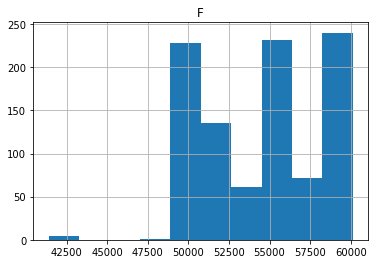

In [27]:
## Plotting the F column.
hist = ValidateDF.hist(column='F')

## Optional: Map the GPS Track using the annotated Magnetic Values

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

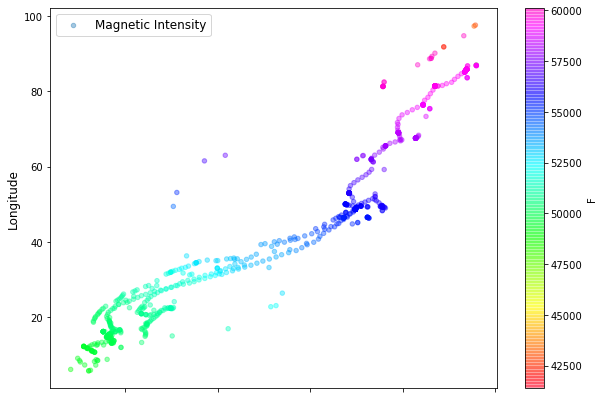

In [28]:
ValidateDF.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="F", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [29]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(ValidateDF, geometry=geopandas.points_from_xy(ValidateDF.Longitude, ValidateDF.Latitude))
gdf.head()

,Latitude,Longitude,Altitude,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,H,D,I,F,geometry
DateTime,,,,,,,,,,,,,,,
2014-09-08 05:54:00,70.854717,68.307333,0.000,21,327.950987,626.701218,1.319048,6950.195375,3846.562150,57704.463629,7943.629908,28.962187,82.161894,58248.659888,POINT (68.30733 70.85472)
2014-09-08 06:10:00,70.830300,67.975050,0.406,21,340.038476,628.953831,1.319048,6986.622060,3861.900714,57646.117115,7982.929596,28.931908,82.115730,58196.236848,POINT (67.97505 70.83030)
2014-09-08 06:26:00,70.761717,67.752417,0.498,26,348.223318,656.804069,1.200000,7035.862674,3874.626421,57610.695473,8032.191075,28.841432,82.062880,58167.932114,POINT (67.75242 70.76172)
2014-09-08 06:42:00,70.686517,67.561983,0.787,26,355.472899,657.901776,1.200000,7083.226913,3884.207475,57575.741152,8078.314874,28.738907,82.013104,58139.703649,POINT (67.56198 70.68652)
2014-09-08 07:14:00,70.685450,67.548317,0.337,26,355.980432,657.921513,1.200000,7086.257042,3885.842751,57585.573172,8081.758024,28.738744,82.011091,58149.918748,POINT (67.54832 70.68545)


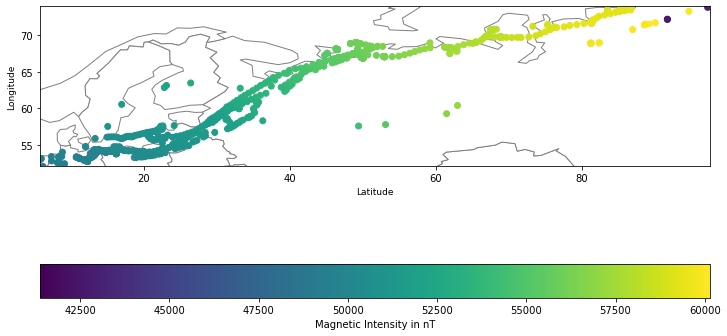

In [30]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='gray', figsize = (12,12))

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

gdf.plot(ax=ax, column='F', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(686.1045454545454, 0.5, 'Longitude')

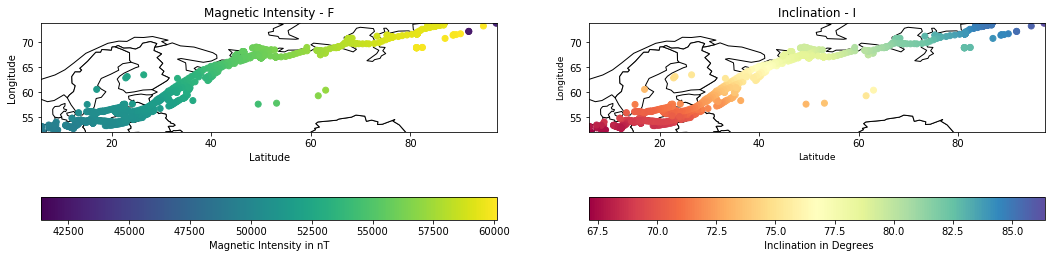

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (18,8))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='F', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='I', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Inclination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Inclination - I')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

## Export the final results to a CSV file

In [32]:
#Exporting the CSV file
os.chdir(r"../results")
outputfile ="GeoMag_"+gpsfilename
export_csv = GPS_ResInt.to_csv (outputfile, index = None, header=True)